In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

figure_dims = (20,20)

In [2]:
import preprocess 

In [3]:
df_applications, df_decisions, df_family_reunion = preprocess.load_data()

In [7]:
nr_countries = 24
select_column = 'applications'

In [8]:
df_group_merged, out, out_sm,  top_countries_new = preprocess.merge_all(df_applications, df_decisions, df_family_reunion,nr_countries, select_column)

# Preproces (formatting) output:

The format we created is a timeseries for each quarter for the top countries in term of asylum applications 

We also calculated a smoothed average. Since we are after a baseline, and the data is quite noisy on the individual country level, the smoothed curve is the one we will try to predict.



In [9]:
out.head(3)

Nationality,Iran,Pakistan,Iraq,Afghanistan,Eritrea,Syria,Sudan,Albania,Sri Lanka,Bangladesh,...,Libya,Somalia,Zimbabwe,Ethiopia,Stateless,Egypt,Yemen,"Gambia, The",Uganda,Other
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,437.0,529.0,133.0,551.0,141.0,39.0,126.0,51.0,376.0,0.0,...,0.0,181.0,618.0,23.0,0.0,0.0,0.0,110.0,62.0,334.0
2010-04-01,414.0,533.0,94.0,478.0,189.0,36.0,154.0,0.0,357.0,129.0,...,0.0,172.0,603.0,25.0,21.0,35.0,10.0,118.0,72.0,123.0
2010-07-01,688.0,467.0,143.0,368.0,236.0,35.0,191.0,57.0,407.0,136.0,...,0.0,165.0,393.0,27.0,0.0,0.0,0.0,112.0,65.0,457.0


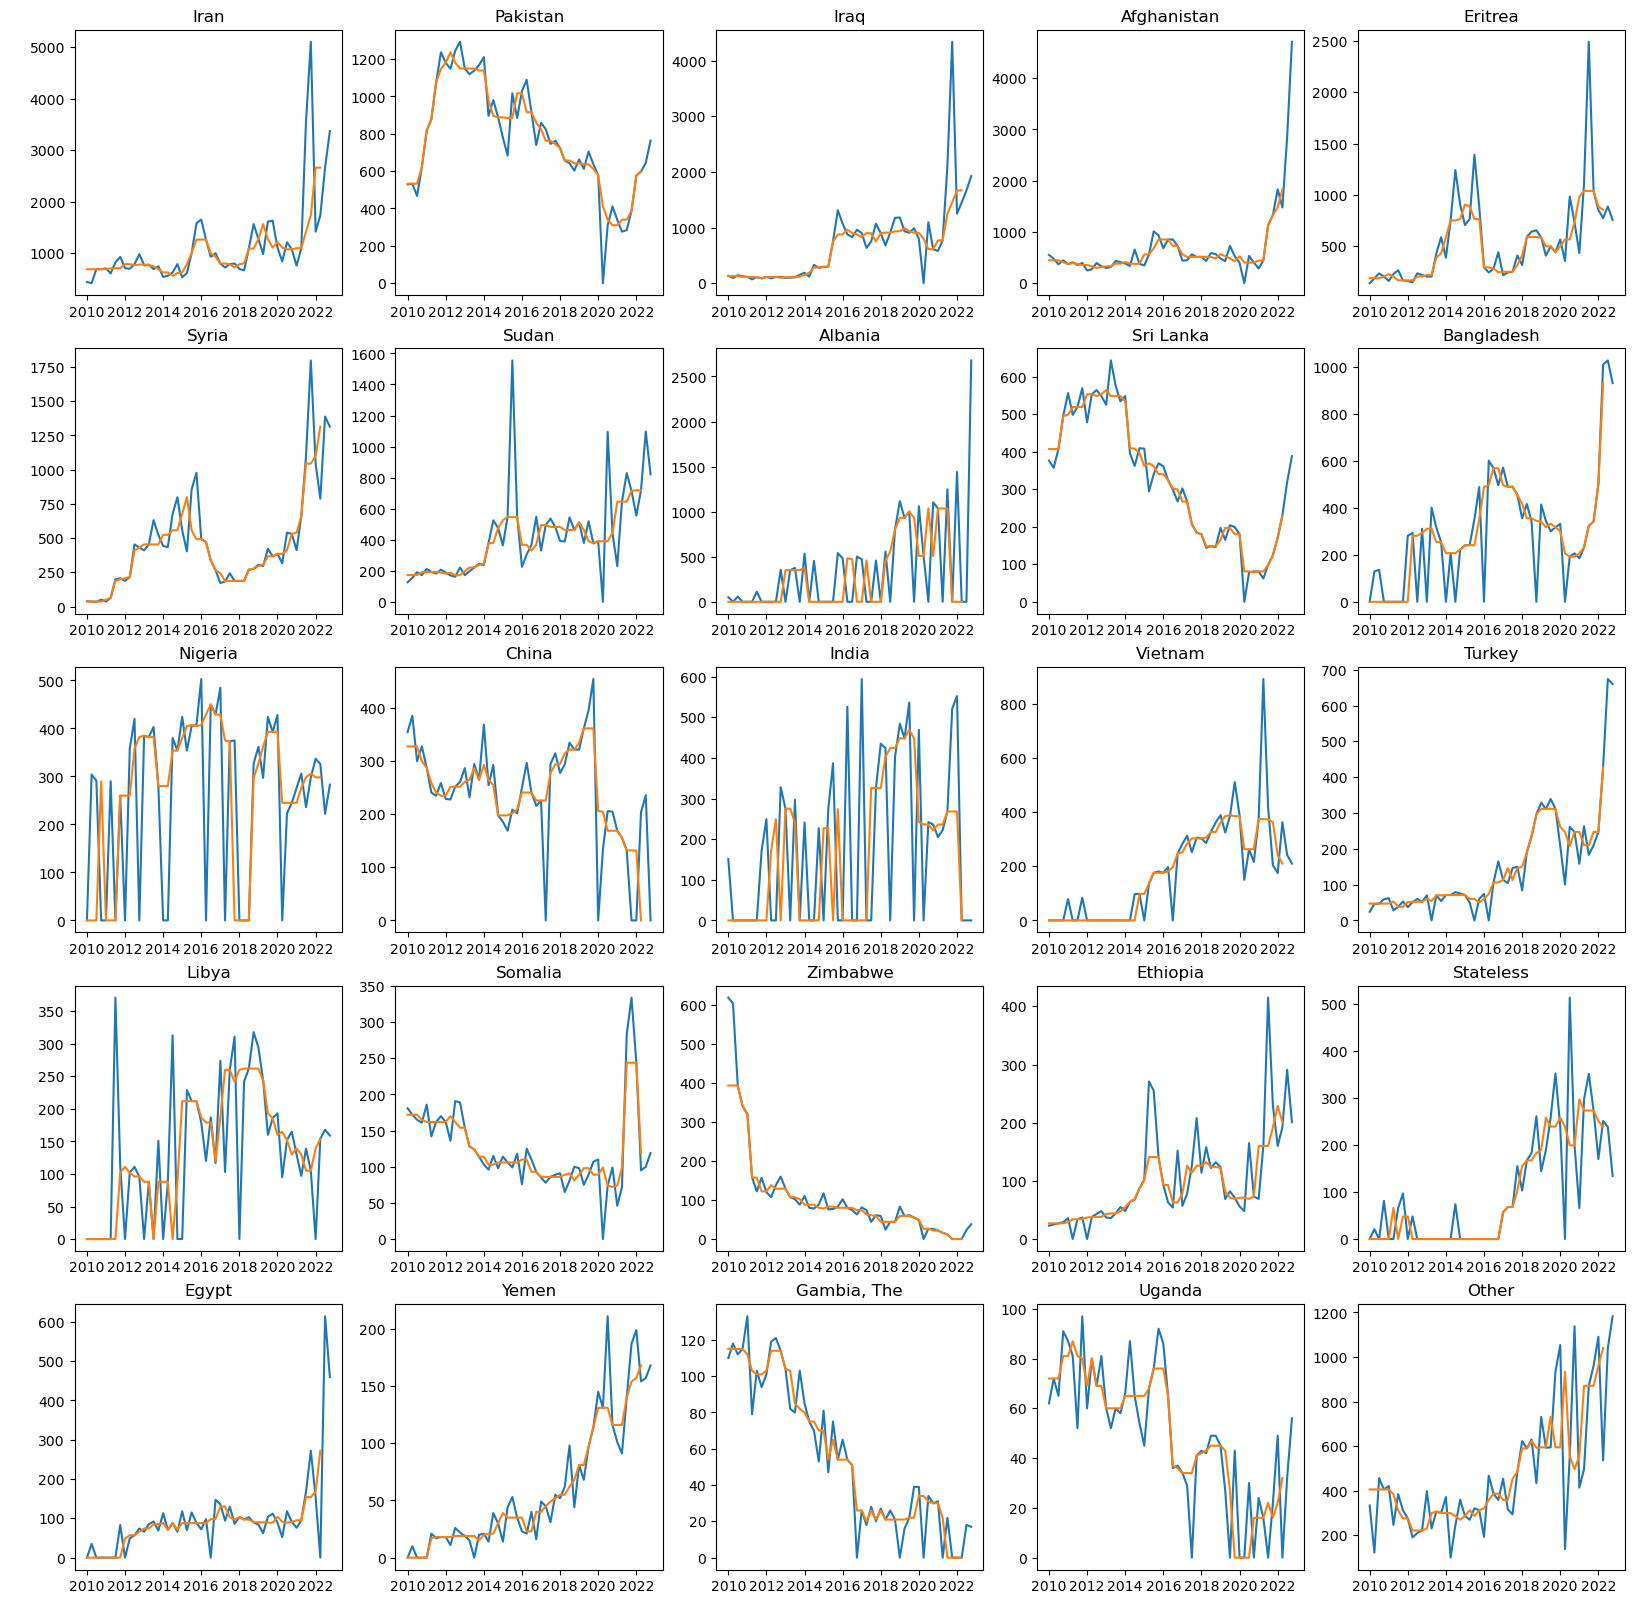

In [10]:
names = out.columns

fig, axes = plt.subplots(5, 5, figsize = figure_dims)

for name, ax in zip(names, axes.flatten()):
    dat = out[name]
    dat_smth = out_sm[name]
    sns.lineplot(data = dat, ax=ax).set_title(name)
    sns.lineplot(data = dat_smth, ax=ax).set_title(name)
    ax.set(xlabel=' ', ylabel=' ')

# Cross-validation on Arima timeseries prediction:

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

We will cross-validate separate splitted time windows, each time taking the immediate timeseries after time cutoff as the true series and the everything prior as train

As validation, we will take the last 3 samples

In [82]:
t_end = dat.index[-3]

For simplicity we are only searching for parameters p,q, d that are the same for each country

In [78]:
summary = pd.DataFrame()
instance = 0

for p in [0,1,2]:
    for d in [0,1]:
        for q in [0,1,2,3]:
            instance = instance+1
            #tscv = TimeSeriesSplit(n_splits = 8)
            tscv = TimeSeriesSplit(n_splits = 4)
            for name in names:
                dat_smth = out_sm[name]
                cross_validation = dat_smth.copy().dropna()
                cross_validation.index = pd.DatetimeIndex(cross_validation.index.values,
                               freq=cross_validation.index.inferred_freq)
                rmse = []
                counting = 0
                for train_index, test_index in tscv.split(cross_validation):
                    counting = counting +1

                    cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
                    #model = sm.tsa.arima.ARIMA(cv_train, order=(1,1,2))
                    model = sm.tsa.arima.ARIMA(cv_train, order=(p,d,q))
                    try:
                        arma = model.fit()
                        predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
                        true_values = cv_test.values
                        xxx = np.sqrt(mean_squared_error(true_values, predictions))
                    except:
                        xxx = 9999
                    rmse.append(xxx)

            print('parameters:', name, p, d, q)
            print("avg RMSE: {}".format(np.mean(rmse)))

            s = pd.Series([p,d,q,np.mean(rmse)], index = ['p','d','q','rms'])
            df = pd.DataFrame(s).T

            summary = summary.append([df])

parameters: Other 0 0 0
avg RMSE: 208.50616329101334
parameters: Other 0 0 1
avg RMSE: 204.13487953599304
parameters: Other 0 0 2
avg RMSE: 201.4296386234269
parameters: Other 0 0 3
avg RMSE: 192.95752858408136
parameters: Other 0 1 0
avg RMSE: 159.3553361496709
parameters: Other 0 1 1
avg RMSE: 167.33236112516715
parameters: Other 0 1 2
avg RMSE: 165.62391553797454
parameters: Other 0 1 3
avg RMSE: 166.2023385301456
parameters: Other 1 0 0
avg RMSE: 157.47060879467764
parameters: Other 1 0 1
avg RMSE: 155.9264740175014
parameters: Other 1 0 2
avg RMSE: 160.33431286372527
parameters: Other 1 0 3
avg RMSE: 165.78669165188336
parameters: Other 1 1 0
avg RMSE: 170.79526210256893
parameters: Other 1 1 1
avg RMSE: 182.71388976189115
parameters: Other 1 1 2
avg RMSE: 167.69380005611907
parameters: Other 1 1 3
avg RMSE: 189.78697217055043
parameters: Other 2 0 0
avg RMSE: 155.71112445202243
parameters: Other 2 0 1
avg RMSE: 173.0763385878892
parameters: Other 2 0 2
avg RMSE: 174.4206300179568

In [83]:
summary.sort_values(by = 'rms').head(7)

,p,d,q,rms
0,2.0,0.0,0.0,155.711124
0,1.0,0.0,1.0,155.926474
0,2.0,1.0,2.0,156.726807
0,1.0,0.0,0.0,157.470609
0,0.0,1.0,0.0,159.355336
0,1.0,0.0,2.0,160.334313
0,0.0,1.0,2.0,165.623916


# Run the model on each country and assess quality:

In [96]:
# chosen model parameters:
p = 2
d = 0
q = 0 

In [100]:
def makepred(dat, dat_smth, p, d, q, name):
    train = dat_smth[:t_end]
    train.index = pd.DatetimeIndex(train.index.values,
                           freq=train.index.inferred_freq)
    test  = dat[t_end:]
    try:
        model = sm.tsa.arima.ARIMA(train, order=(p,d,q))
        arma = model.fit()
        predictions = arma.predict(test.index.values[0], test.index.values[-1])
    except:
        print(name, 'reverting to different order model')
        model = sm.tsa.arima.ARIMA(train, order=(0,1,0))
        arma = model.fit()
        predictions = arma.predict(test.index.values[0], test.index.values[-1])    
    return predictions

Zimbabwe reverting to different order model


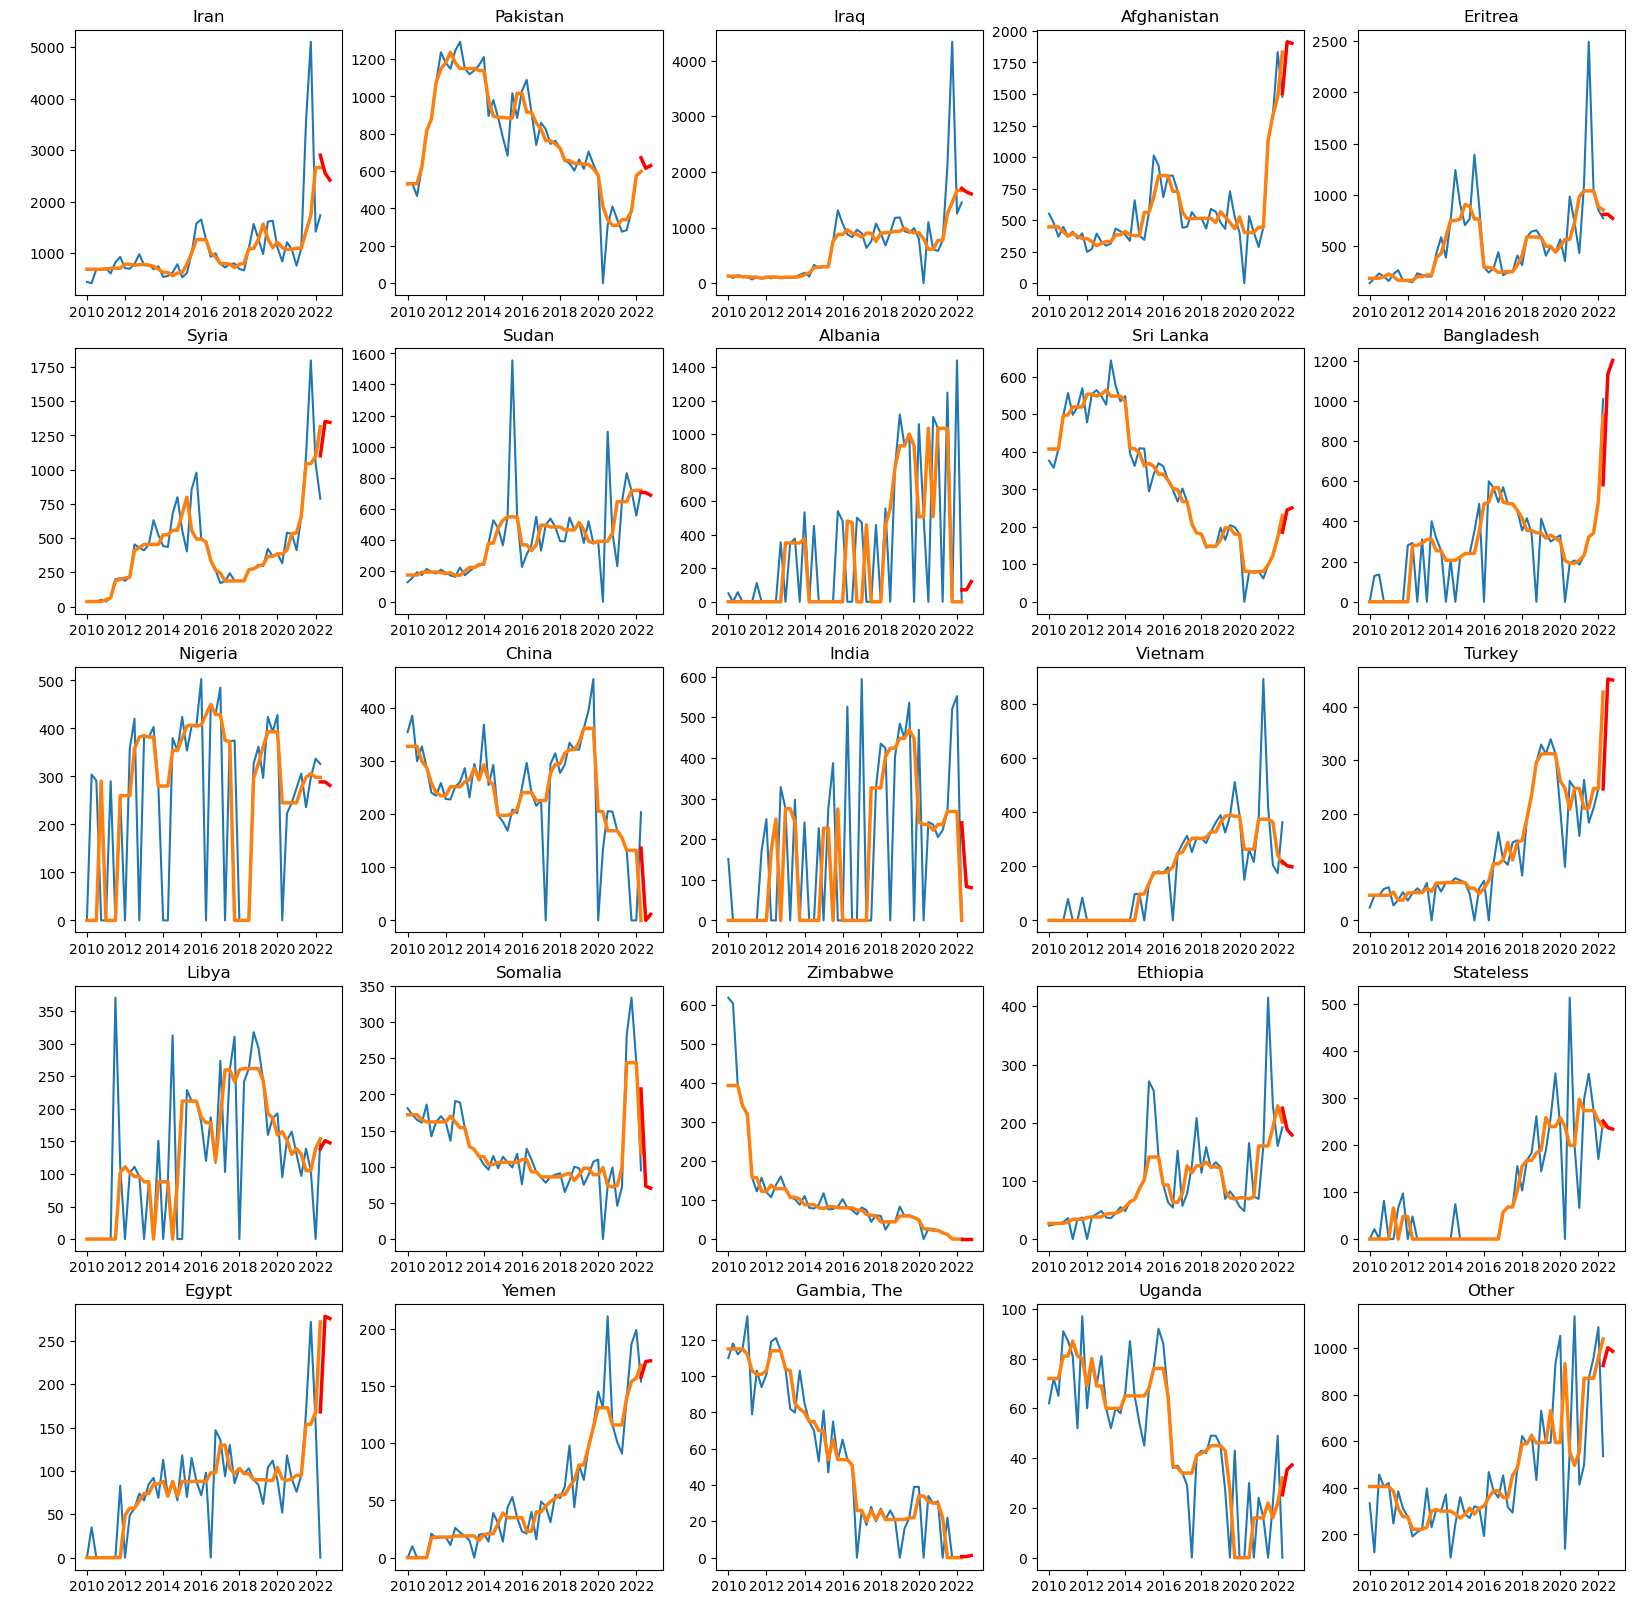

In [101]:
names = out.columns

fig, axes = plt.subplots(5, 5, figsize = figure_dims)

for name, ax in zip(names, axes.flatten()):
    dat = out[name]
    dat_smth = out_sm[name]
    pred = makepred(dat, dat_smth, p, d, q, name)
    sns.lineplot(data = dat[:t_end], ax=ax).set_title(name)
    sns.lineplot(data = dat_smth[:t_end], ax=ax, linewidth=2.5).set_title(name)
    sns.lineplot(data = pred, ax=ax, color='red', linewidth=2.5).set_title(name)
    ax.set(xlabel=' ', ylabel=' ')

# Assess accuracy of Rolled up average:

In [105]:
# All in 1 go
smooth_plus_pred = out.copy()
for name in names:
    dat = out[name]
    dat_smth = out_sm[name]
    pred = makepred(dat, dat_smth, p, d, q, name)
    dat_new = dat.copy()
    dat_new[:t_end] = dat_smth[:t_end]
    dat_new[t_end:] = pred
    smooth_plus_pred[name] = dat_new

Zimbabwe reverting to different order model


[Text(0, 0.5, 'visa per quarter'), Text(0.5, 0, 'Date')]

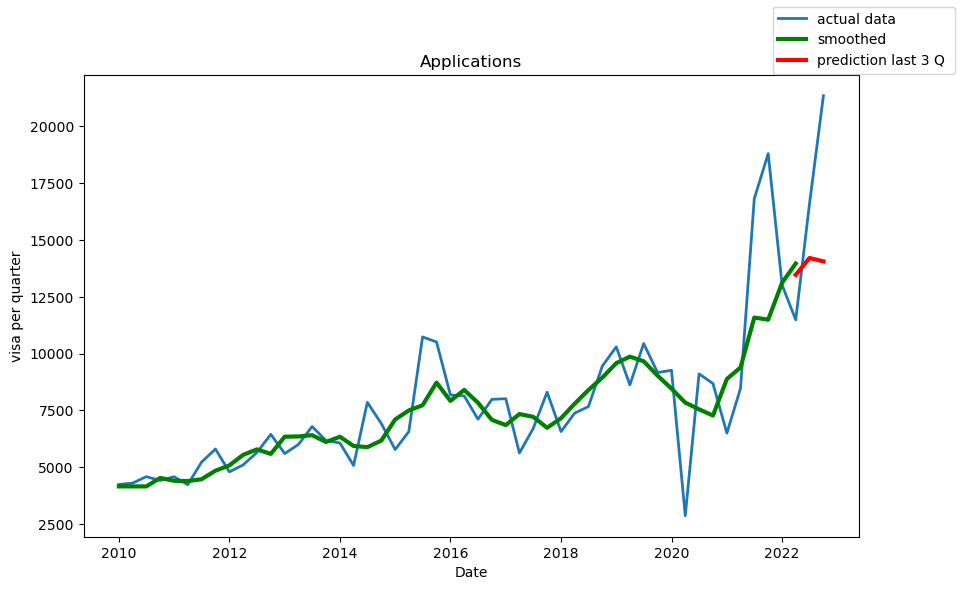

In [121]:
line1 = out.sum(axis =1)
line2 = out_sm.sum(axis =1)
line3 = smooth_plus_pred.sum(axis =1)

fig, ax = plt.subplots(1, 1, figsize = (10,6))


sns.lineplot(data = line1, ax=ax, linewidth=2.0)
sns.lineplot(data = line2, ax=ax, color='green', linewidth=3.0, linestyle = "-")
sns.lineplot(data = line3[t_end:], ax=ax, color='red', linewidth=3.0).set_title('Applications')
#.set_title('Total Visa Granted')

fig.legend(['actual data','smoothed','prediction last 3 Q '])

ax.set(ylabel='visa per quarter', xlabel='Date')